In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
!pip install mplfinance
import mplfinance as mpf
plt.style.use('seaborn-deep')

You should consider upgrading via the '/home/yarka/anaconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
def parse(x):
    return datetime.datetime.strptime(x, '%Y-%m-%d')

df = pd.read_csv('TSLA.csv',  parse_dates = True, index_col=0, date_parser=parse)
df.columns = ['Open', 'High', 'Low', 'Close', 'Adj_close', 'Volume']
df.index.name = 'Date'

In [3]:
print('First observation date: %s \nLast observation date: %s' % (df.index[0].date(), df.index[-1].date()))

First observation date: 2010-06-29 
Last observation date: 2020-02-03


In [4]:
df.head(8)


,Open,High,Low,Close,Adj_close,Volume
Date,,,,,,
2010-06-29,19.000000,25.000000,17.540001,23.889999,23.889999,18766300
2010-06-30,25.790001,30.420000,23.299999,23.830000,23.830000,17187100
2010-07-01,25.000000,25.920000,20.270000,21.959999,21.959999,8218800
2010-07-02,23.000000,23.100000,18.709999,19.200001,19.200001,5139800
2010-07-06,20.000000,20.000000,15.830000,16.110001,16.110001,6866900
2010-07-07,16.400000,16.629999,14.980000,15.800000,15.800000,6921700
2010-07-08,16.139999,17.520000,15.570000,17.459999,17.459999,7711400
2010-07-09,17.580000,17.900000,16.549999,17.400000,17.400000,4050600


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2416 entries, 2010-06-29 to 2020-02-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2416 non-null   float64
 1   High       2416 non-null   float64
 2   Low        2416 non-null   float64
 3   Close      2416 non-null   float64
 4   Adj_close  2416 non-null   float64
 5   Volume     2416 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 132.1 KB


In [6]:
df.describe()

,Open,High,Low,Close,Adj_close,Volume
count,2416.000000,2416.000000,2416.000000,2416.000000,2416.000000,2.416000e+03
mean,186.271147,189.578224,182.916639,186.403651,186.403651,5.572722e+06
std,118.740163,120.892329,116.857591,119.136020,119.136020,4.987809e+06
min,16.139999,16.629999,14.980000,15.800000,15.800000,1.185000e+05
25%,34.342498,34.897501,33.587501,34.400002,34.400002,1.899275e+06
50%,213.035003,216.745002,208.870002,212.960007,212.960007,4.578400e+06
75%,266.450012,270.927513,262.102501,266.774994,266.774994,7.361150e+06
max,673.690002,786.140015,673.520020,780.000000,780.000000,4.706500e+07


In [7]:
print(np.var(df.Close - df.Adj_close)) #drop one since they are identical

0.0


In [8]:
df.drop(['Adj_close'], inplace = True, axis = 1)
c_names = [name for name in df.columns]

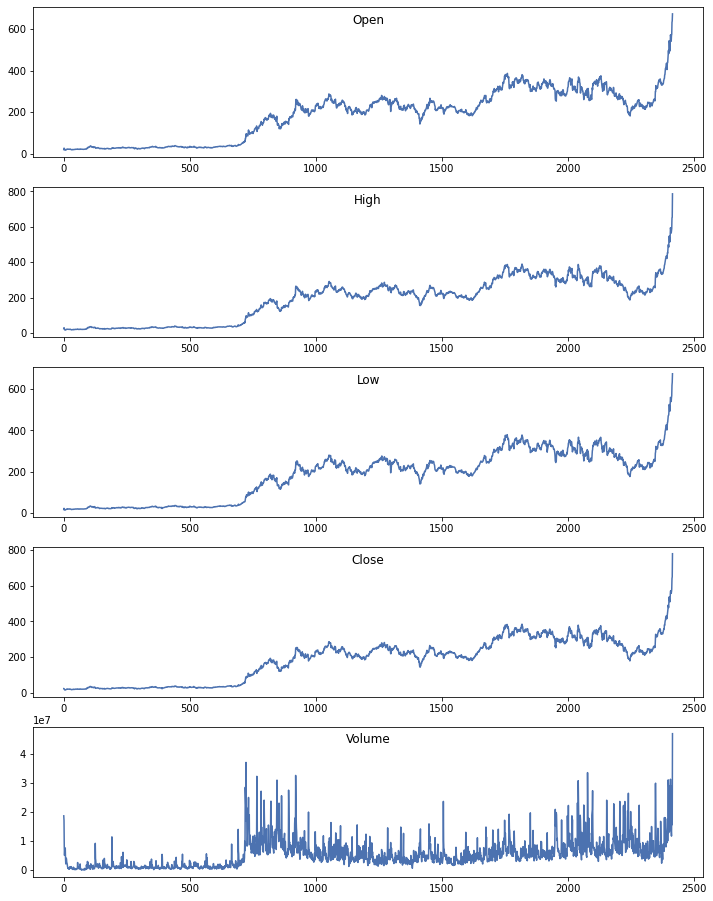

In [9]:

values = df.values

num_f = len(df.columns)

groups = [x for x in range(num_f)]

plt.figure(figsize = (12,16))

i = 1
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.85, loc='center')
    i += 1
plt.show()

Here we see that last days Tesla Stocks experienced exploding growth. This behaviour hasn't occurred previously and it is interesting how the LSTM model will predict the day next to the historical dataset final date

In [10]:
def series_to_supervised(data, c_names, n_in=1, n_out=1, dropnan=True):
    '''
    This function reformats the dataset the way it can be fed to the LSTM.
    '''
    n_vars = 1 if type(data) is list else data.shape[1]
   
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):

        cols.append(df.shift(i))
        names += ['%s(t-%d)' % (n, i) for n in c_names]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % n) for n in c_names]
        else:
            names += [('%s(t+%d)' % (n, i)) for n in c_names]
   
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [11]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [12]:
# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

n_days_back = 21
n_days_future = 1
n_features = num_f

# frame as supervised learning
reframed = series_to_supervised(scaled, c_names, n_days_back, n_days_future)

print(reframed.head(5))

    Open(t-21)  High(t-21)  Low(t-21)  Close(t-21)  Volume(t-21)  Open(t-20)  \
21    0.004349    0.010877   0.003887     0.010586      0.397214    0.014676   
22    0.014676    0.017920   0.012634     0.010508      0.363576    0.013474   
23    0.013474    0.012073   0.008033     0.008061      0.172543    0.010433   
24    0.010433    0.008408   0.005664     0.004449      0.106958    0.005870   
25    0.005870    0.004379   0.001291     0.000406      0.143747    0.000395   

    High(t-20)  Low(t-20)  Close(t-20)  Volume(t-20)  ...  Open(t-1)  \
21    0.017920   0.012634     0.010508      0.363576  ...   0.006707   
22    0.012073   0.008033     0.008061      0.172543  ...   0.007041   
23    0.008408   0.005664     0.004449      0.106958  ...   0.006174   
24    0.004379   0.001291     0.000406      0.143747  ...   0.006631   
25    0.000000   0.000000     0.000000      0.144914  ...   0.007391   

    High(t-1)  Low(t-1)  Close(t-1)  Volume(t-1)   Open(t)   High(t)  \
21   0.005549 

That way our dataset is transformed the way it has 5 inputs for 21 days back to predict one day ahead.

Now, let's split the dataset into training and testing parts and then into X and y parts.

In [13]:
n_obs = n_days_back * n_features

target_idx = [reframed.columns.to_list().index(col) for col in reframed.columns[n_obs:] if 'Open' in col]


# split into train and test sets
values = reframed.values

n_train_days = 2000

train = values[:n_train_days, :]
test = values[n_train_days:, :]

In [14]:
train_X, train_y = train[:, :n_obs], train[:, target_idx]
test_X, test_y = test[:, :n_obs], test[:, target_idx]

# reshape input to fit the LSTM network requirements: [n_samples, window, n_features]
train_X = train_X.reshape((train_X.shape[0], n_days_back, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days_back, n_features))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2000, 21, 5) (2000, 1) (395, 21, 5) (395, 1)


In [15]:
#This part is responsible for modeling and model training:
# design network
model = Sequential()
model.add(LSTM(150, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(train_y.shape[1]))

checkpoint = ModelCheckpoint('w.hdf5', monitor='val_loss', save_best_only=True)

callback_list = [checkpoint]

model.compile(optimizer = 'adam', loss = root_mean_squared_error)

t = model.fit(train_X, train_y, epochs=50,
              batch_size=32,
              validation_data=(test_X, test_y),
              verbose=1,
              callbacks = callback_list,
              shuffle=False)

model.load_weights('w.hdf5')

Epoch 1/50
63/63 [==============================] - 2s 32ms/step - loss: 0.0200 - val_loss: 0.0287
Epoch 2/50
63/63 [==============================] - 2s 33ms/step - loss: 0.0194 - val_loss: 0.0240
Epoch 3/50
63/63 [==============================] - 2s 28ms/step - loss: 0.0130 - val_loss: 0.0198
Epoch 4/50
63/63 [==============================] - 1s 21ms/step - loss: 0.0103 - val_loss: 0.0229
Epoch 5/50
63/63 [==============================] - 1s 21ms/step - loss: 0.0113 - val_loss: 0.0179
Epoch 6/50
63/63 [==============================] - 1s 22ms/step - loss: 0.0077 - val_loss: 0.0168
Epoch 7/50
63/63 [==============================] - 1s 22ms/step - loss: 0.0084 - val_loss: 0.0177
Epoch 8/50
63/63 [==============================] - 1s 20ms/step - loss: 0.0107 - val_loss: 0.0176
Epoch 9/50
63/63 [==============================] - 1s 20ms/step - loss: 0.0106 - val_loss: 0.0162
Epoch 10/50
63/63 [==============================] - 1s 20ms/step - loss: 0.0098 - val_loss: 0.0158
Epoch 11/

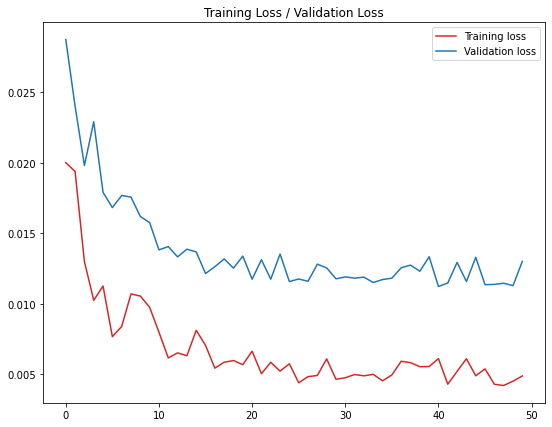

In [16]:
# plot training history
plt.figure(figsize = (9,7))
plt.title('Training Loss / Validation Loss')
plt.plot(t.history['loss'], 'tab:red', label='Training loss')
plt.plot(t.history['val_loss'], 'tab:blue', label='Validation loss')
plt.legend()
plt.show()

In [17]:
# make a prediction
yhat = model.predict(test_X)

# invert scaling
yhat_inv = yhat / scaler.scale_[0]
y_inv = test_y / scaler.scale_[0]

# reshape back
yhat_inv_rshp = yhat_inv.reshape((-1,1))
y_inv_rshp = y_inv.reshape((-1,1))

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_inv_rshp, yhat_inv_rshp))
print('Test set RMSE: %.2f' % rmse)

Test set RMSE: 8.39


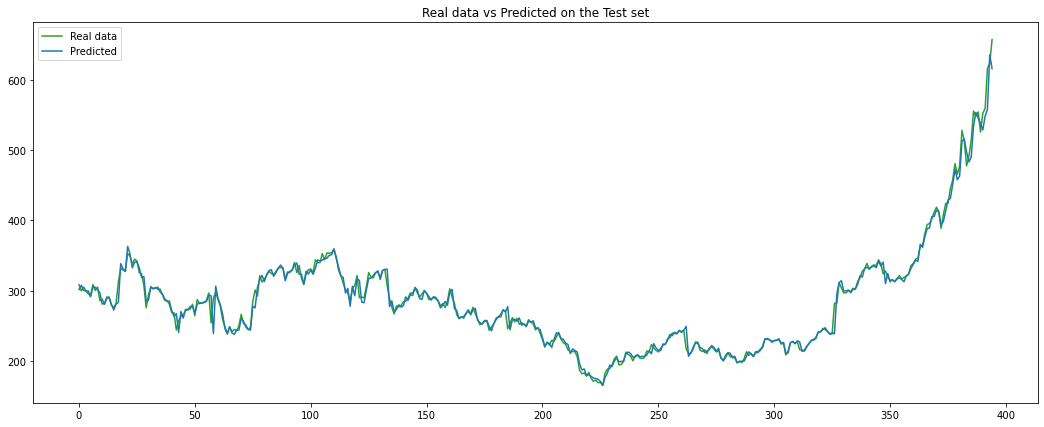

In [18]:
plt.figure(figsize = (18,7))
plt.title('Real data vs Predicted on the Test set')
plt.plot(y_inv_rshp, 'tab:green', label='Real data')
plt.plot(yhat_inv_rshp, 'tab:blue', label='Predicted')
plt.legend()
plt.show()

In [19]:
print(f'Initial set size: {df.shape[0]}')
print(f'Train set X size: {train_X.shape[0]}, train set y size: {train_y.shape[0]}')
print(f'Test set X size: {test_X.shape[0]}, test set y size: {test_y.shape[0]}')

Initial set size: 2416
Train set X size: 2000, train set y size: 2000
Test set X size: 395, test set y size: 395


In [20]:
reframed.tail(1)

,Open(t-21),High(t-21),Low(t-21),Close(t-21),Volume(t-21),Open(t-20),High(t-20),Low(t-20),Close(t-20),Volume(t-20),...,Open(t-1),High(t-1),Low(t-1),Close(t-1),Volume(t-1),Open(t),High(t),Low(t),Close(t),Volume(t)
2415,0.621033,0.538096,0.617624,0.542345,0.200518,0.645365,0.568375,0.64072,0.559029,0.376173,...,0.948764,0.826981,0.937741,0.830633,0.33231,1.0,1.0,1.0,1.0,1.0


In [21]:
last_day = reframed.iloc[-1:, -n_obs:]
last_day = last_day.values
last_day = last_day.reshape((-1, n_days_back, n_features))

t_plus_one = model.predict(last_day)
t_plus_one /= scaler.scale_[0]
print('Last observation\'s date in the dateset is %s\nLast observation\'s value is %.2f' % (df.index[-1].date(), df.iloc[-1, 0]))
print('\nPredicted observation\'s date is %s\nPredicted observation\'s value is %.2f' % (df.index[-1].date() + datetime.timedelta(days=1), t_plus_one))
print('\nReal value for %s is %.2f' % (df.index[-1].date() + datetime.timedelta(days=1), 882.96))

Last observation's date in the dateset is 2020-02-03
Last observation's value is 673.69

Predicted observation's date is 2020-02-04
Predicted observation's value is 774.87

Real value for 2020-02-04 is 882.96
